In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./ES_ML_SOSSO/colors.css", "r").read()
    return HTML(styles)
css_styling()

# Pint of Science 2019
## Machine Learning: Navigating the Hype

<img src="./PoS_2019/Logo_1.png" width="700">

In [2]:
%%capture
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="white", color_codes=True)
from sklearn import tree
import graphviz
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

### The dataset from tonight...

In [11]:
tn = pd.read_csv("/Users/wolf/Downloads/pint19.csv",header=6)
tn.drop(tn.tail(1).index,inplace=True)
tn = tn.drop(['Student Names','Student ID', 'Total Score (0 - 100)',
       'Number of correct answers'], axis=1);
tn.rename(columns={'How old are you?':'Age'}, inplace=True)
tn.rename(columns={'With which gender do you most identify?':'Gender'}, inplace=True)
tn.rename(columns={'My annual income is...':'Income'}, inplace=True)
tn.columns
tn

,Age,Gender,Income
0,23.0,Male,less than 50K GBP
1,30.0,Female,less than 50K GBP
2,30.0,Female,less than 50K GBP
3,24.0,Female,less than 50K GBP
4,26.0,Male,less than 50K GBP
5,25.0,Female,less than 50K GBP
6,32.0,Female,less than 50K GBP
7,31.0,Female,less than 50K GBP
8,36.0,Female,more than 50K GBP
9,31.0,Male,less than 50K GBP


TypeError: unorderable types: str() < float()

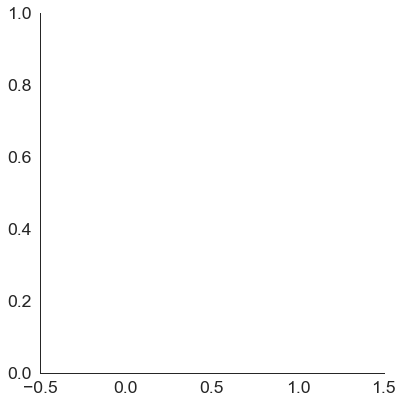

In [10]:
# Let's have a look...
sns.set_context("paper", font_scale=2.0, rc={"font.size":20,"axes.labelsize":20})
sns.catplot(x="Income", y="Age", data=tn, kind='swarm', hue="Gender",height=6, s=20, marker='o');

In [92]:
# Remove invalid data...
tn = tn[(tn.astype(str) != ' ?').all(axis=1)]

# >50K = 1, <=50K = 0
tn['Income'] = tn.apply(lambda row: 1 if 'more'in row['Income'] else 0, axis=1)

# Use one-hot encoding on categorial columns
tn = pd.get_dummies(tn, columns=['Gender'])

In [93]:
# shuffle rows
tn = tn.sample(frac=1)

# Split training and testing data
d_train = tn
d_train_att = d_train.drop(['Income'], axis=1)
d_train_gt50 = d_train['Income']
d_att = tn.drop(['Income'], axis=1)
d_gt50 = tn['Income']

In [94]:
# Number of income > 50K in whole dataset:
print("Income >50K: %d out of %d (%.2f%%)" % (np.sum(d_gt50), len(d_gt50), 100*float(np.sum(d_gt50)) / len(d_gt50)))

Income >50K: 6 out of 11 (54.55%)


In [95]:
# Let's build a decision tree classifier...
t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
t = t.fit(d_train_att, d_train_gt50)

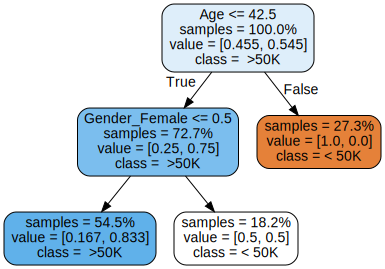

In [96]:
# Let's have a look at this tree...
dot_data = tree.export_graphviz(t, out_file=None, label='all', impurity=False, proportion=True, 
                               feature_names=list(d_train_att), class_names=['< 50K', ' >50K'],
                               filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [103]:
# Make a prediction! 1 = > 50 k, 0 = < 50 k
tmp = d_att.iloc[0]
print("From tonight's dataset...")
print()
print(tmp)
print()
print("Actual outcome",d_gt50.iloc[0])
print("Predicted outcome:",t.predict([tmp]))

From tonight's dataset...

Age               43
Gender_Diverse     0
Gender_Female      1
Gender_Male        0
Name: 3, dtype: int64

Actual outcome 0
Predicted outcome: [0]


In [107]:
# Let's push it a bit...
tmp = [33, 0, 0, 1]
print("Let's push it a bit...")
print()
print(tmp)
print()
print("Predicted outcome:",t.predict([tmp]))

Let's push it a bit...

[33, 0, 0, 1]

Predicted outcome: [1]


In [108]:
# How are we doing?
#print(d_att)
pred = t.predict(d_att)
pred = pred[:, None]
actual = d_gt50[:,None]
print(np.concatenate((pred,actual),axis = 1))

[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]]


In [109]:
scores = cross_val_score(t, d_att, d_gt50, cv=5)
# Show avarage score and +/- two standard deviations away (covering 95% or scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))
# Accuracy: 0.83 (+/- 0.00)

Accuracy: 0.53 (+/- 0.90)


In [79]:
# for max_depth in range(1, 20):
#     t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
#     scores = cross_val_score(t, d_att, d_gt50, cv=5)
#     print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))

### A much more extensive dataset...

In [125]:
df = pd.read_csv("./PoS_2019/adult_train.csv")

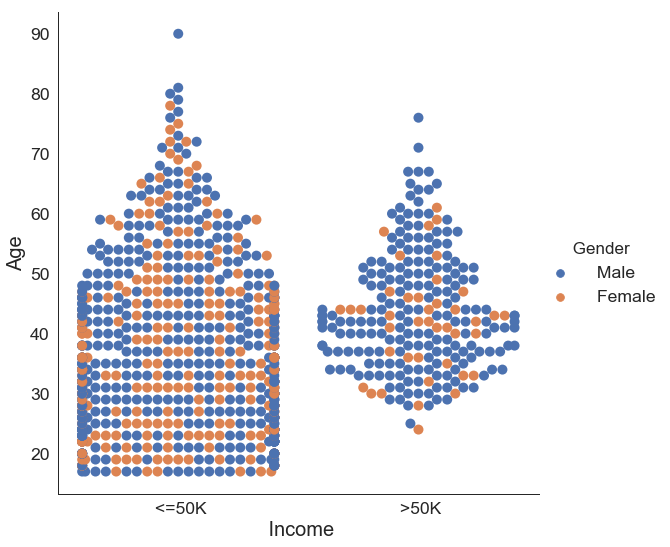

In [126]:
# smaller chunk, just to test...
hw = 1000
df_small = df.iloc[:hw, :]

#print(df_small)

# swarm plot with hue
sns.set_context("paper", font_scale=2.0, rc={"font.size":20,"axes.labelsize":20})
sns.catplot(x=" Income", y="Age", data=df_small, kind='swarm', hue=" Gender",height=8, s=10);

In [127]:
len(df_small)
#df_small.columns

# Remove invalid data from table
df_small = df_small[(df_small.astype(str) != ' ?').all(axis=1)]
len(df_small) # 30162

# >50K = 1, <=50K = 0
df_small[' Income'] = df_small.apply(lambda row: 1 if '>50K'in row[' Income'] else 0, axis=1)

# Remove useless columns
df_small = df_small.drop([' NaN', ' NaN.1', ' NaN.2', ' NaN.3', ' NaN.4'], axis=1)

# Use one-hot encoding on categorial columns
df_small = pd.get_dummies(df_small, columns=[' School', ' Education', ' Status', ' Job', ' Status_T', ' Race', ' Gender', ' Country'])

#print(df_small)

In [128]:
# shuffle rows
df_small = df_small.sample(frac=1)
# split training and testing data
half = int(hw/2)
d_train = df_small[:250]
d_test = df_small[250:]
d_train_att = d_train.drop([' Income'], axis=1)
d_train_gt50 = d_train[' Income']
d_test_att = d_test.drop([' Income'], axis=1)
d_test_gt50 = d_test[' Income']
d_att = df_small.drop([' Income'], axis=1)
d_gt50 = df_small[' Income']
# number of income > 50K in whole dataset:
print("Income >50K: %d out of %d (%.2f%%)" % (np.sum(d_gt50), len(d_gt50), 100*float(np.sum(d_gt50)) / len(d_gt50)))
# Income >50K: 105 out of 461 (22.78%)

Income >50K: 221 out of 922 (23.97%)


In [129]:
# Fit a decision tree
t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
t = t.fit(d_train_att, d_train_gt50)

In [115]:
tmp = d_test_att.iloc[0]
print(tmp)
print(t.predict([tmp]))

Age                               49
 School_ Federal-gov               0
 School_ Local-gov                 0
 School_ Private                   1
 School_ Self-emp-inc              0
 School_ Self-emp-not-inc          0
 School_ State-gov                 0
 Education_ 10th                   0
 Education_ 11th                   0
 Education_ 12th                   0
 Education_ 1st-4th                0
 Education_ 5th-6th                0
 Education_ 7th-8th                0
 Education_ 9th                    0
 Education_ Assoc-acdm             0
 Education_ Assoc-voc              0
 Education_ Bachelors              0
 Education_ Doctorate              0
 Education_ HS-grad                1
 Education_ Masters                0
 Education_ Preschool              0
 Education_ Prof-school            0
 Education_ Some-college           0
 Status_ Divorced                  0
 Status_ Married-AF-spouse         0
 Status_ Married-civ-spouse        1
 Status_ Married-spouse-absent     0
 

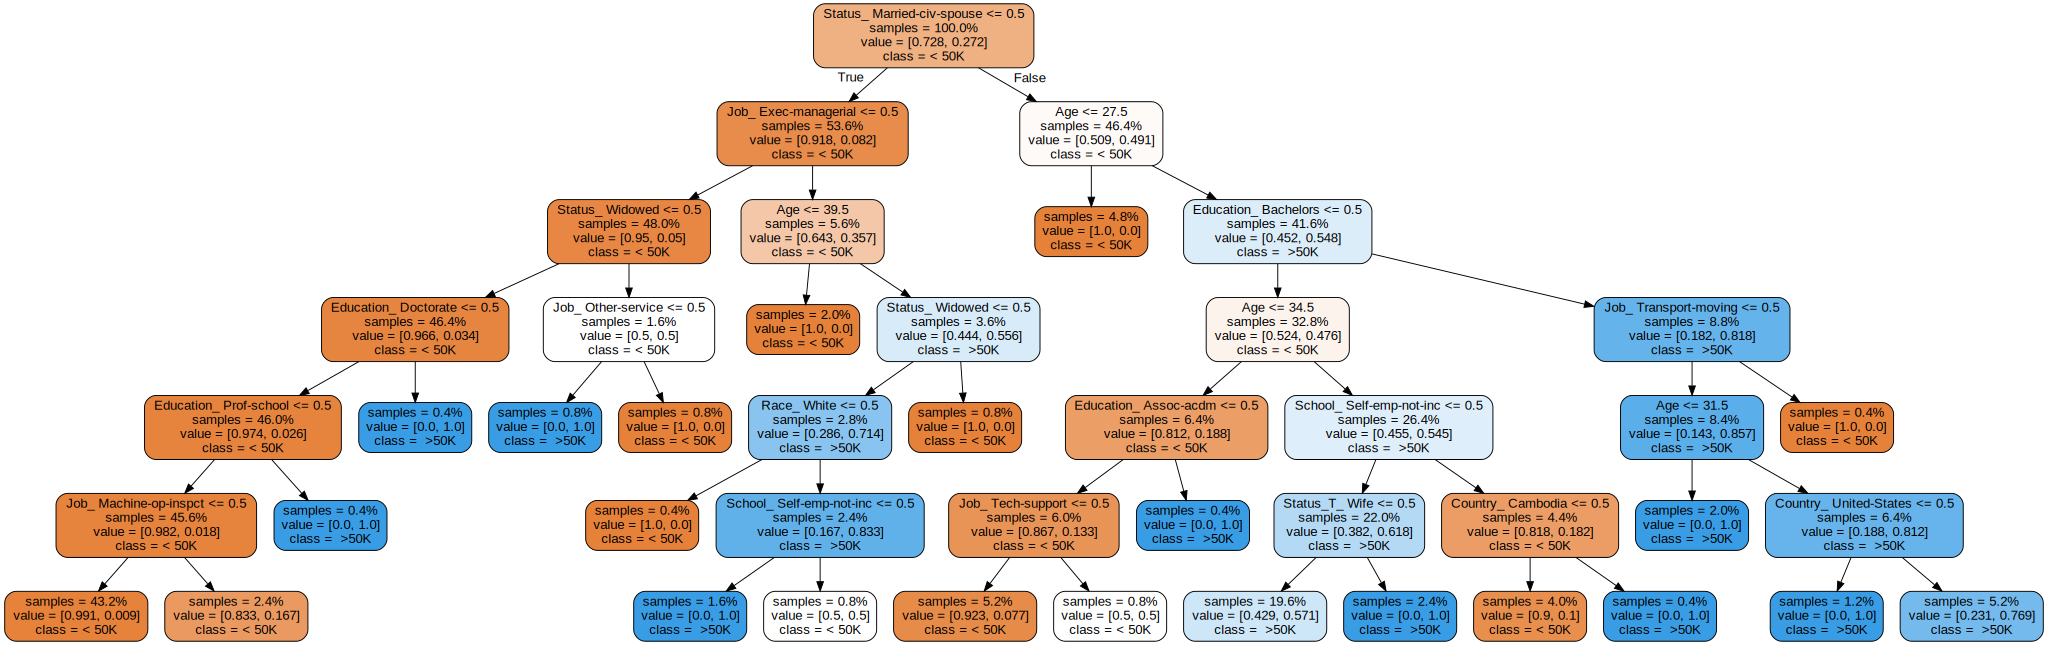

In [130]:
# Visualize tree
dot_data = tree.export_graphviz(t, out_file=None, label='all', impurity=False, proportion=True, 
                               feature_names=list(d_train_att), class_names=['< 50K', ' >50K'],
                               filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [131]:
scores = cross_val_score(t, d_test_att, d_test_gt50, cv=100)
# Show avarage score and +/- two standard deviations away (covering 95% or scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))

Accuracy: 0.82 (+/- 0.22)


In [66]:
# for max_depth in range(1, 20):
#     t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
#     scores = cross_val_score(t, d_test_att, d_test_gt50, cv=100)
#     print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std()*2))